# Understanding detection power

At it's simplest, detection power is the probability of detecting some difference given the sample size, and the random variation in the observed data.

Of importance are a couple of definition:
* **Receptor**: The receptor is the location where the concentration is measured.  This is typically a groundwater well, stream or lake.
* **Source**: The source is the location where the concentration is changed.  This is typically a point source (e.g. a wastewater treatment plant) or a non-point source (e.g. a catchment/groundwater source area).
* **Noise**: here by noise we include the variation in the concentration at the receptor. This includes true sampling noise, but also includes any other variation in the concentration at the receptor that cannot be identified or corrected for (e.g. from weather events etc.). Typically, the noise will be estimated as the standard deviation of the receptor concentration time series (assuming no trend), or the standard deviation of the residuals from a model (e.g. linear regression) of the receptor concentration time series.
* **True Receptor Concentration**: The true receptor concentration is the concentration at the receptor if there was no noise.

Very noisy data will have a large noise to signal ratio, and so it will be difficult to detect a change in concentration.  Conversely, if the data is not very noisy, then it will be easier to detect a change in concentration.  For example in the figures below it is much easier to see the true change in concentration in the blue data than the red data.

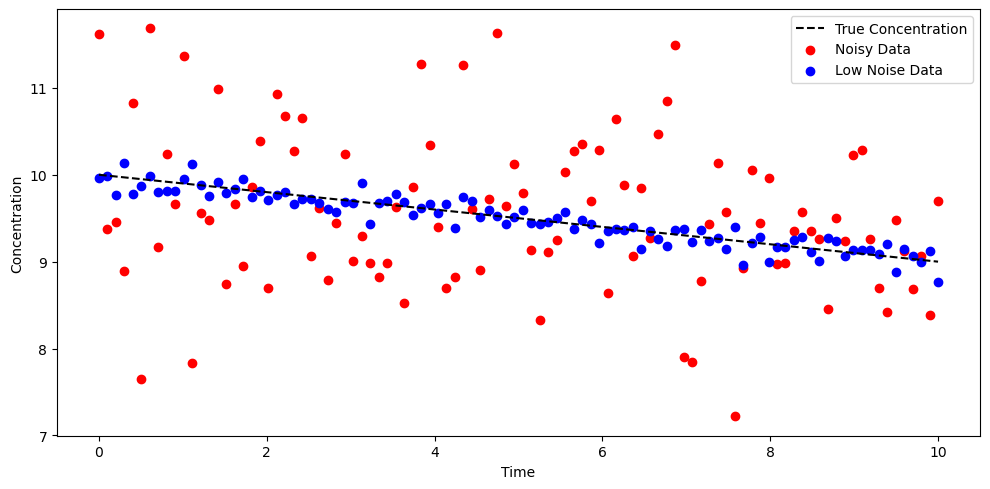

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 5))

# generate some random data
x = np.linspace(0, 10, 100)
y_true = -0.1 * x + 10
np.random.seed(1) # set the random seed, so we get the same random numbers each time
y_noisy = y_true + np.random.normal(0, 1, len(x))
np.random.seed(2)
y_low_noise = y_true + np.random.normal(0, 0.1, len(x))
ax.plot(x, y_true, ls ='--', c='k', label='True Concentration')
ax.scatter(x, y_noisy, c='r', label='Noisy Data')
ax.scatter(x, y_low_noise, c='b', label='Low Noise Data')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.legend()
fig.tight_layout()
plt.show()

## What question are you asking (slope vs Counterfactual)

Most of the time it's not about "seeing" the change but having a statistical test identify the change. The most important question becomes "What question are you asking?".  There are two main questions that can be asked using the detection power framework here:

1. **Identify a Slope**: Is there a slope change in the concentration at the receptor?  For instance are we seeing a reduction in the concentration of the receptor over time?
2. **Counterfactual**: Is the concentration at the receptor different in our alternative scenario than our base scenario?  For instance, is the concentration at receptor different if we take some management action (e.g. implement land surface reductions) rather than the status quo?

The first question is answered using the DetectionPowerSlope and AutoDetectionPowerSlope classes.  The second question is answered using the DetectionPowerCounterfactual and AutoDetectionPowerCounterfactual classes. The counterfactual question can be further broken down into three sub-questions:

1. **alt!=base**: Is the concentration at the receptor different in the alternative scenario than the base scenario?
2. **alt>base**: Is the concentration at the receptor greater in the alternative scenario than the base scenario?
3. **alt<base**: Is the concentration at the receptor less in the alternative scenario than the base scenario?


## Visualising Slope detection power

As an example let's look further at the time series data above. What happens to the detection power across a range of error values and sampling frequencies?  

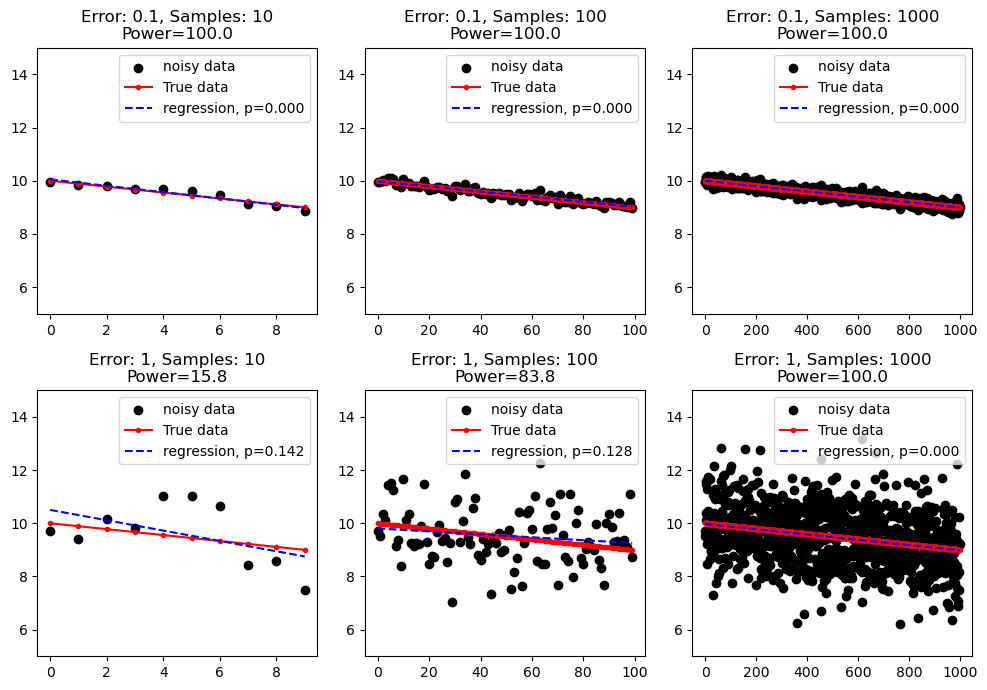

In [6]:
from gw_detect_power import DetectionPowerSlope
import numpy as np
import matplotlib.pyplot as plt

errors = [0.1, 1]
samples = [10, 100, 1000]

dpc = DetectionPowerSlope(significance_mode='linear-regression', nsims=1000, min_p_value=0.05,
                          return_true_conc=True, return_noisy_conc_itters=1)

fig, axs = plt.subplots(nrows=len(errors), ncols=len(samples), figsize=(10, 7))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        x = np.linspace(0, 10, nsamp)
        y_true = -0.1 * x + 10
        out = dpc.power_calc('temp', error=error, true_conc_ts=y_true, seed=5654)
        fig0, ax = dpc.plot_iteration(y0=out['noisy_conc'].iloc[:, 0], true_conc=y_true, ax=axs[i,j])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()

## Visualising Counterfactual detection power

Similarly

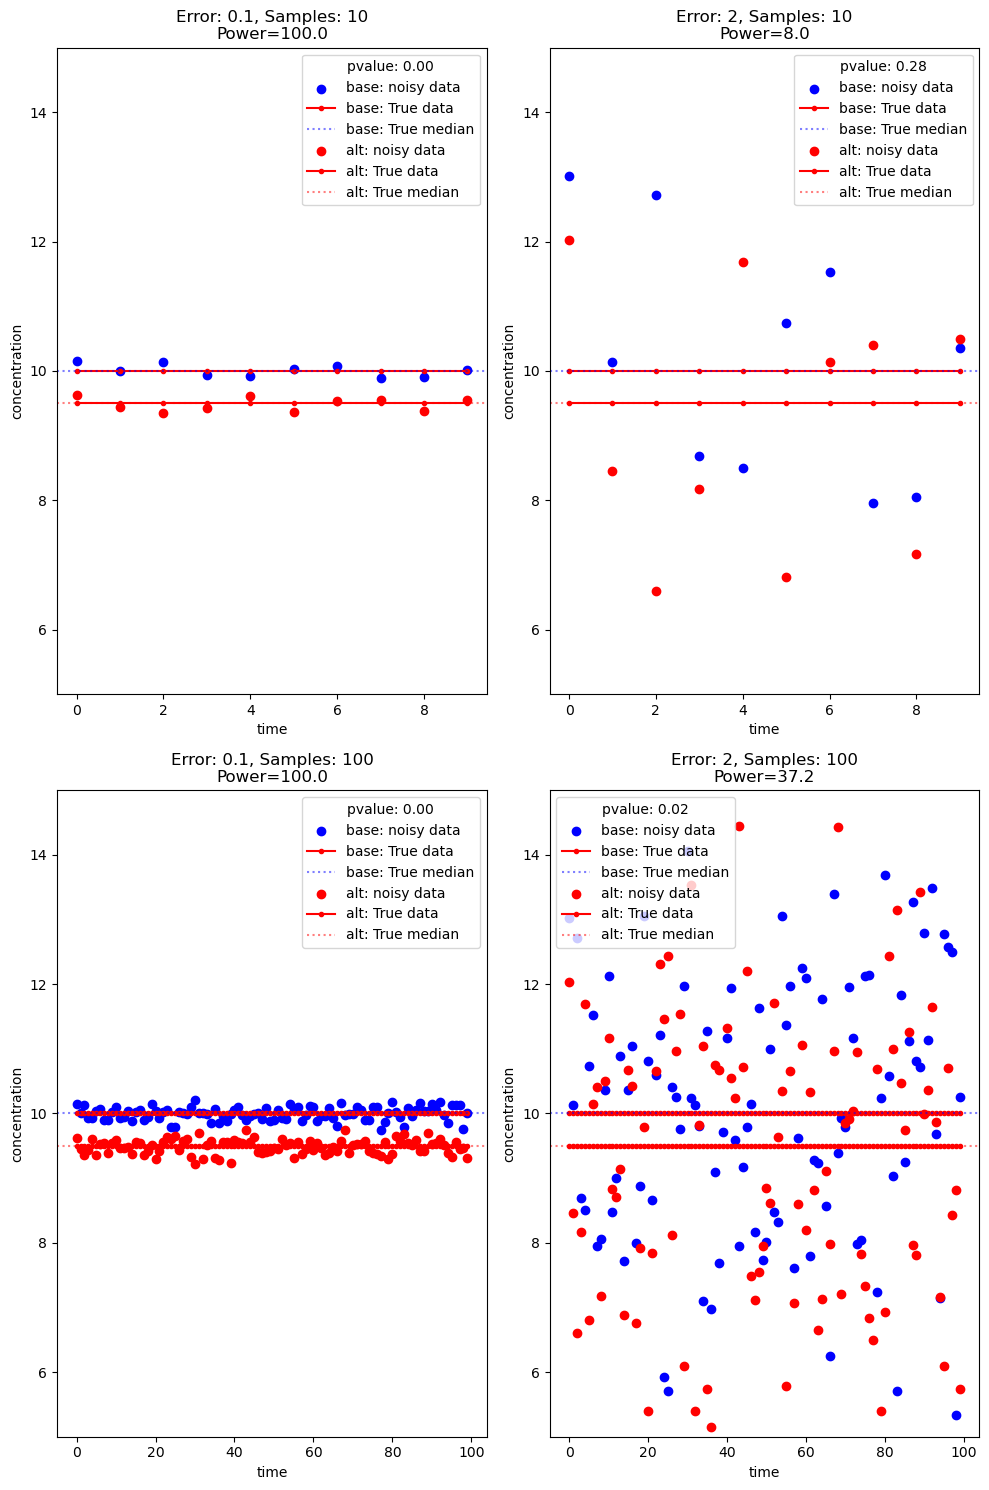

In [7]:
from gw_detect_power import DetectionPowerCounterFactual
import numpy as np
import matplotlib.pyplot as plt

errors = [0.1, 2]
samples = [10, 100]

dpc = DetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test', nsims=1000, p_value=0.05,
                                   alternative='alt!=base',
                                   return_true_conc=True, return_noisy_conc_itters=1)

fig, axs = plt.subplots(nrows=len(samples), ncols=len(errors), figsize=(10, 15))

for i, error in enumerate(errors):
    for j, nsamp in enumerate(samples):
        # generate some random data
        ybase = np.full(nsamp, 10, )
        y_alt = np.full(nsamp, 9.5, )
        out = dpc.power_calc('temp', error_base=error, true_conc_base=ybase, true_conc_alt=y_alt, seed_base=5454,
                             seed_alt=5654)
        y0_alt = out['alt_noisy_conc'].iloc[:, 0]
        y0_base = out['base_noisy_conc'].iloc[:, 0]
        fig0, ax = dpc.plot_iteration(y0_base, y0_alt, true_conc_base=ybase, true_conc_alt=y_alt, ax=axs[j, i])
        ax.set_title(f'Error: {error}, Samples: {nsamp}\nPower={out["power"].loc["power"]:.1f}')
        ax.set_ylim(5, 15)

fig.tight_layout()
plt.show()